Setup

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/BreastCancerDataset"

In [ ]:
%cd /content/gdrive/MyDrive/BreastCancerDATASET/

!kaggle datasets download -d paultimothymooney/breast-histopathology-images

In [ ]:
import zipfile
import time
from tqdm.notebook import tqdm

zf = zipfile.ZipFile('/content/gdrive/MyDrive/BreastCancerDATASET/breast-histopathology-images.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

Imports

In [15]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

Load Data

In [ ]:
ids = os.listdir("/content/gdrive/MyDrive/BreastCancerDATASET/")
data = []
for id in tqdm(ids):
  try:
    files1 = os.listdir('/content/gdrive/MyDrive/BreastCancerDATASET/' + id + '/1/')
    files0 = os.listdir('/content/gdrive/MyDrive/BreastCancerDATASET/' + id + '/0/')
    for x in files1:
      data.append('/content/gdrive/MyDrive/BreastCancerDATASET/' + id + '/1/' + x)
    for x in files0:
      data.append('/content/gdrive/MyDrive/BreastCancerDATASET/' + id + '/0/' + x)
  except:
    FileNotFoundError
len(data)

  0%|          | 0/282 [00:00<?, ?it/s]

277524

In [ ]:
import random

random.shuffle(data)
np.savetxt("dataBreastCancerFinal.txt", np.array(data), fmt="%s")

In [ ]:
txtfile = open('dataBreastCancerFinal.txt')
data = txtfile.read().split('\n')
len(data)

277525

Vizualization

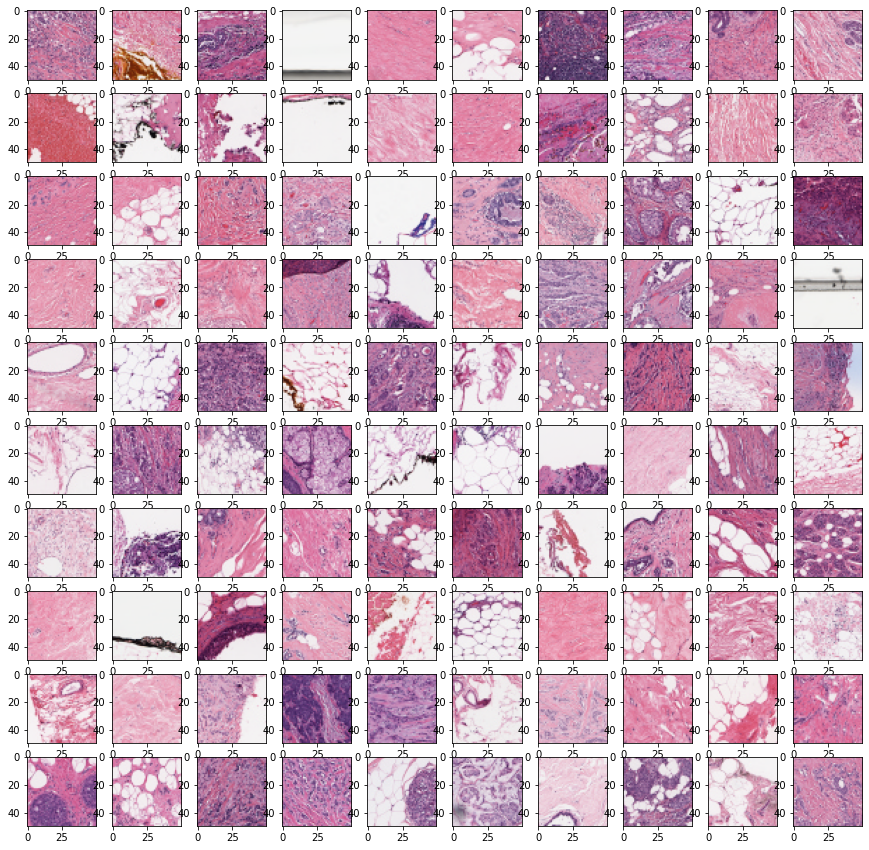

In [ ]:
w = 20
h = 20
fig = plt.figure(figsize=(15, 15))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = mpimg.imread(data[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Labels and Images creation

In [ ]:
import cv2
from tqdm.notebook import tqdm
import keras_preprocessing.image as IMAGE
from PIL import Image

images=[]
labels=[]
for i in tqdm(data):
    if i.endswith('.png'):
          label = int(i[-5])
          img = IMAGE.img_to_array(IMAGE.load_img(i, target_size=(100, 100)))
          images.append(img)
          labels.append(label)

In [ ]:
ctr=0
for i in range(len(images)):
  labels[i] = int(labels[i])
  if(images[i].shape != (100, 100, 3)):
    ctr=ctr+1
print('Number of images with wrong dimensions: ', ctr)

In [ ]:
print(len(images), len(labels))

for i, x in enumerate(tqdm(images)):
  if(images[i].shape != (100, 100, 3)):
    images.pop(i)
    labels.pop(i)
    
print(len(images), len(labels))

Create Train and Test datasets

In [ ]:
from sklearn.model_selection import train_test_split

y = np.array(labels)
x = np.stack(images)/255

x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=0, test_size=0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Model

In [ ]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(100,100,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])

model.summary()

In [ ]:
import tensorflow as tf

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, verbose = 2, batch_size = 250)

In [ ]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

Prediction and Testing

In [10]:
%cd /content/gdrive/MyDrive/BreastCancerModels/
!ls

/content/gdrive/MyDrive/BreastCancerModels
model10.h5  model13.h5	model2.h5  model5.h5  model8.h5		model.h5
model11.h5  model14.h5	model3.h5  model6.h5  model9.h5
model12.h5  model1.h5	model4.h5  model7.h5  modelDetails.txt


In [9]:
files = os.listdir("/content/gdrive/MyDrive/TestData/")
TestData = []
for f in tqdm(files):
  TestData.append('/content/gdrive/MyDrive/TestData/' + f)
len(TestData)

  0%|          | 0/1000 [00:00<?, ?it/s]

1000

In [ ]:
from keras.models import load_model
import os

# Generated many 14 with different hyperparameters

models = list(filter(lambda x: x.endswith('.h5'), os.listdir('/content/gdrive/MyDrive/BreastCancerModels/')))
names = models
models = list(map(lambda x: load_model(x), models))

In [ ]:
threshold = 0.5
total = len(images)
for modelID, model in enumerate(models):
  correct = 0
  wrong = 0
  for id, image in enumerate(tqdm(images)):
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)[0][0]
    result = 1 if pred>=threshold else 0
    if result == labels[id]:
      correct+=1
    else:
      wrong+=1
  print('For model', names[modelID],' Accuracy:', correct/total,' Correct:', correct, ' Wrong:', wrong)

In [17]:
# Best Model Yet

import tensorflow as tf
import keras_preprocessing.image as IMAGE

model = tf.keras.models.load_model('model.h5')

threshold = 0.5
total = len(TestData)
correct = 0
wrong = 0
for id, image in enumerate(tqdm(TestData)):
  label = int(image[-5])
  img = np.stack(IMAGE.img_to_array(IMAGE.load_img(image, target_size=(100, 100)))) / 255
  pred = model.predict(np.expand_dims(img, axis=0))[0][0]
  result = 1 if pred>=threshold else 0
  if result == label:
    correct+=1
  else:
    wrong+=1
print(' Accuracy:', correct/total,' Correct:', correct, ' Wrong:', wrong)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Accuracy: 0.922  Correct: 922  Wrong: 78
